# Exercício 7 – Clusterização as avessas
Ele possui 2 dimensões e está disponível no diretório da disciplina como ClusterizacaoTrabalho.csv.  
Utilizando as técnicas vistas em sala de aula, realize a melhor clusterização possível para esse conjunto.  

Dicas:  
 - O conjunto possui muitos ruídos;
 - É possível validar visualmente a clusterização dados que o conjunto possui apenas 2 dimensões

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [2]:
data = pd.read_csv('bases/ClusterizacaoTrabalho.csv', engine='python', sep=';')
data.head()

,V1,V2
0,664159,550946
1,665845,557965
2,597173,575538
3,618600,551446
4,635690,608046


In [3]:
# Analisando se existem valores faltantes
print(data.info(),'\n')

# Analisando a composição das variáveis numéricas
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   V1      5000 non-null   int64
 1   V2      5000 non-null   int64
dtypes: int64(2)
memory usage: 78.2 KB
None 

                  V1             V2
count    5000.000000    5000.000000
mean   514937.556600  494709.292800
std    244465.901926  235840.852969
min     19835.000000   51121.000000
25%    320352.500000  320107.750000
50%    505338.500000  526259.500000
75%    786228.750000  713713.500000
max    961951.000000  970756.000000


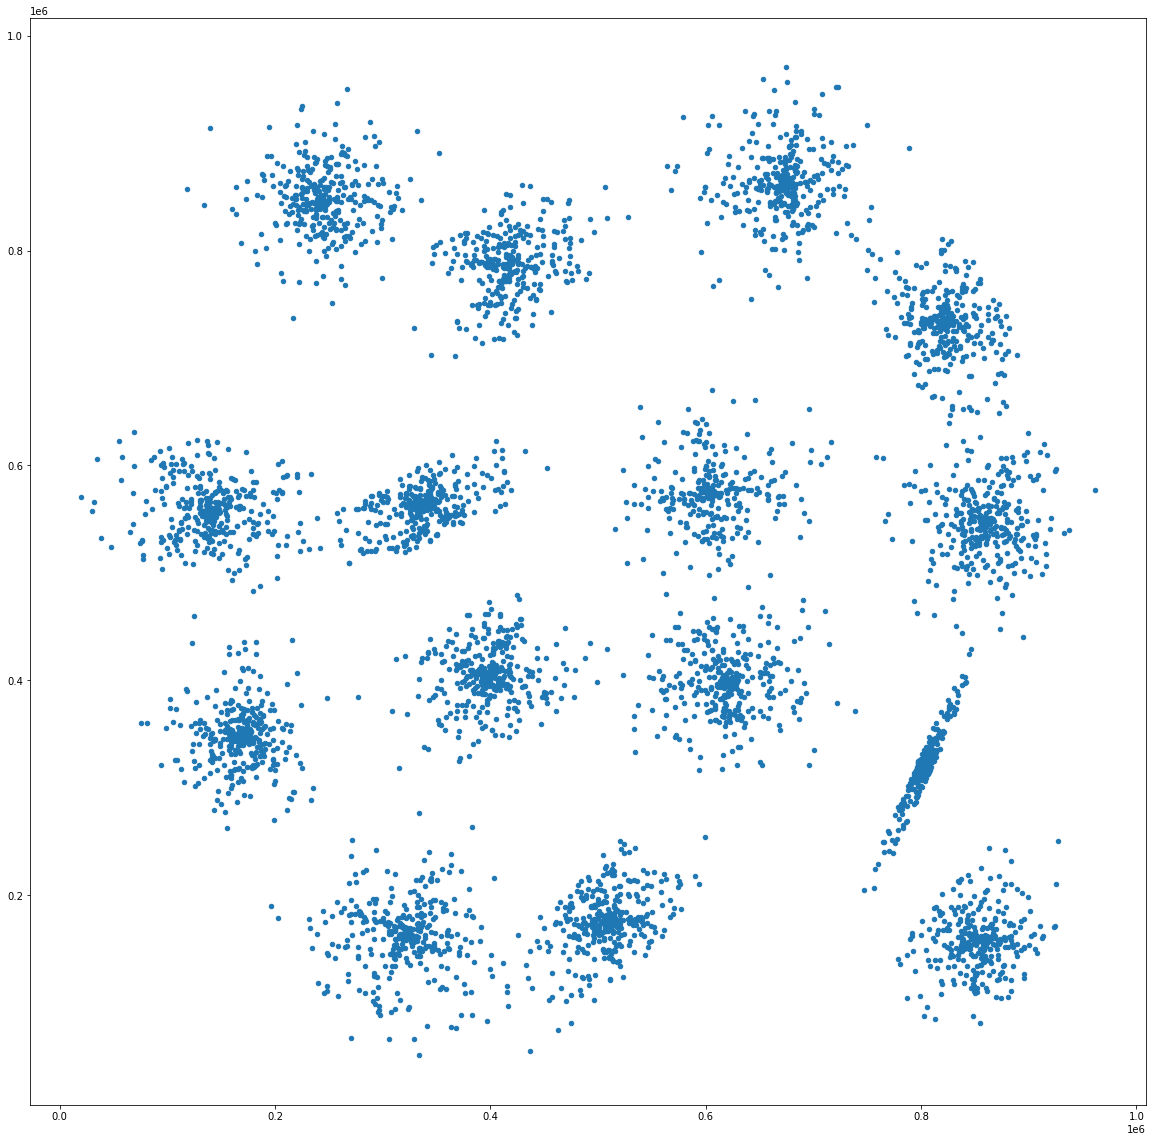

In [4]:
# Visualizando o dataset 

plt.figure(1, figsize=(20,20))
plt.scatter(data.V1, data.V2, s=20)
plt.show();

In [5]:
# Normalizando os dados pelo metodo StandardScaler
data_norm = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns)

data_norm.head()

,V1,V2
0,0.610459,0.238476
1,0.617356,0.268240
2,0.336422,0.342760
3,0.424079,0.240596
4,0.493993,0.480612


## K-Means  

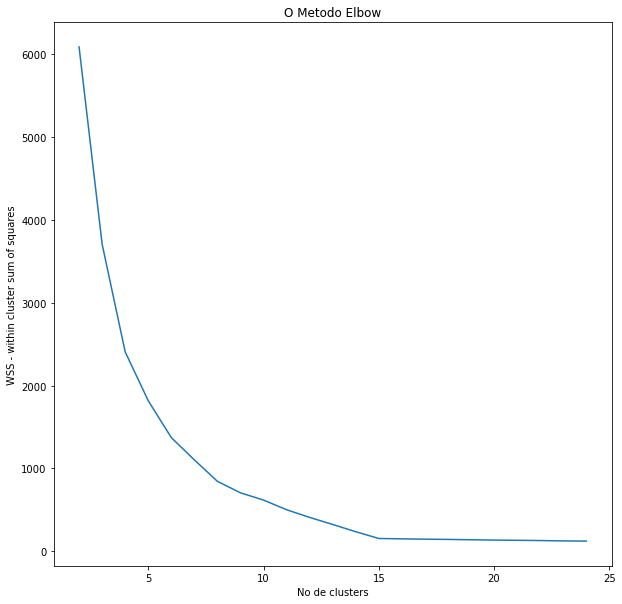

In [6]:
# Visualmente podemos identificar 15 possíveis clusteres, mas vamos utilizar também a metodologia numérica.

inertias =[]
range_n_clusters = range(2, 25)
for i in range_n_clusters:
    kmeans = KMeans(n_clusters = i).fit(data_norm)
    inertias.append(kmeans.inertia_)

plt.figure(2, figsize=(10,10))
plt.plot(range_n_clusters, inertias)
plt.title('O Metodo Elbow')
plt.xlabel('No de clusters')
plt.ylabel('WSS - within cluster sum of squares')
plt.show()

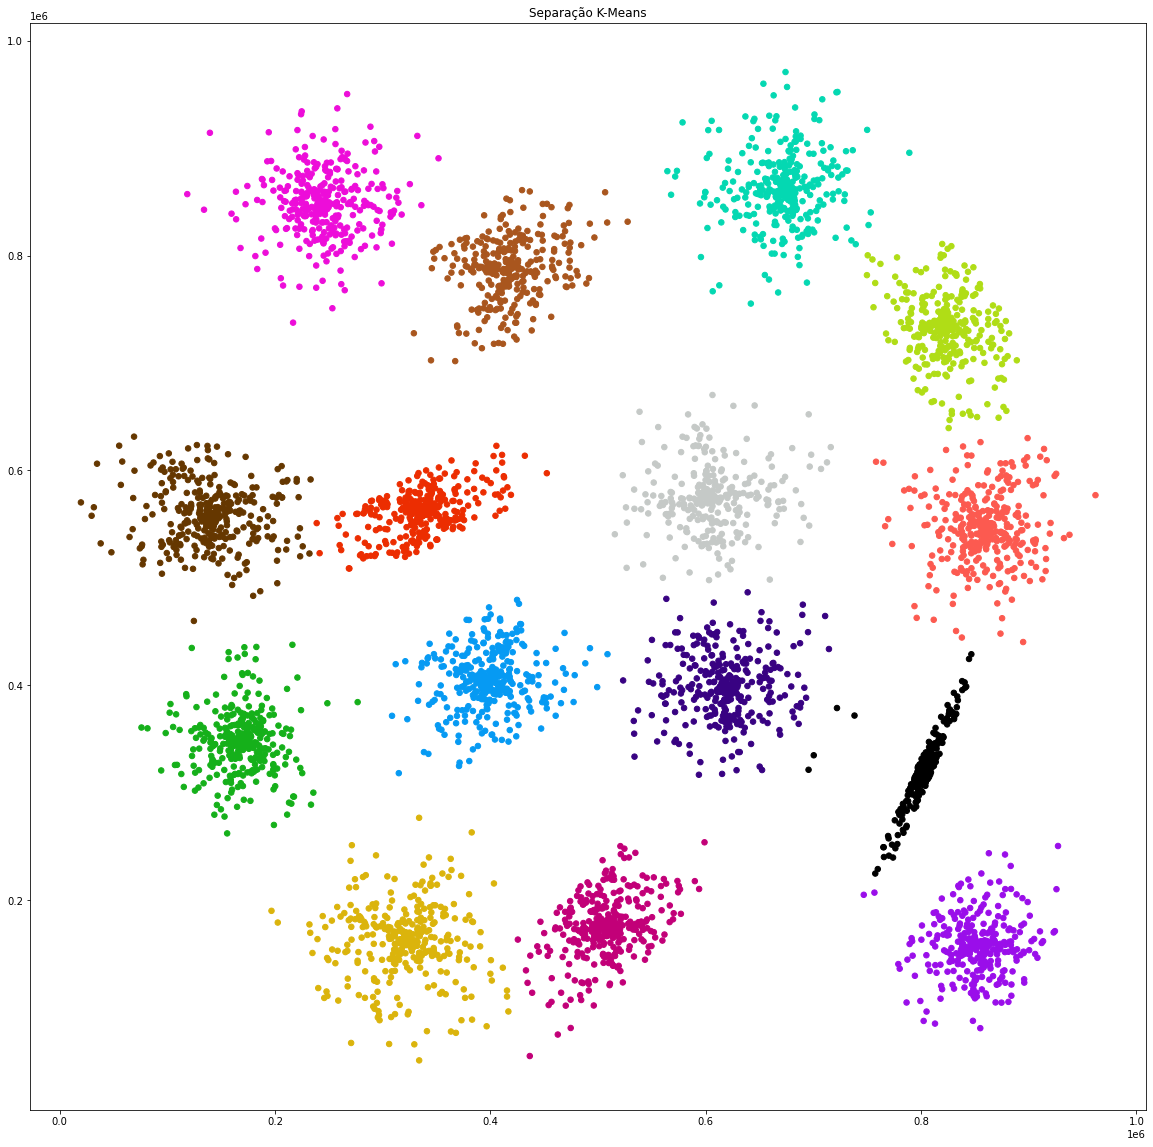

In [7]:
kdata = data_norm.copy()
# A partir do gráfico acima percebemos o que o númedo ideal de clusters está entre 10 e 15, escolhemos o 15 para nosso caso.
kmeans = KMeans(n_clusters = 15, random_state=42)
kmeans.fit(kdata)

xkcd = np.array(['#04d8b2', '#069af3', '#000000', '#653700', '#fc5a50', 
    '#ed0dd9', '#dbb40c', '#15b01a', '#380282', '#c20078', 
    '#a9561e', '#c5c9c7', '#ec2d01', '#9a0eea', '#b0dd16'])

plt.figure(3, figsize=(20,20))
plt.scatter(data.V1, data.V2, c=xkcd[kmeans.labels_], s=30)

plt.title('Separação K-Means')
plt.show();

## DBSCAN  

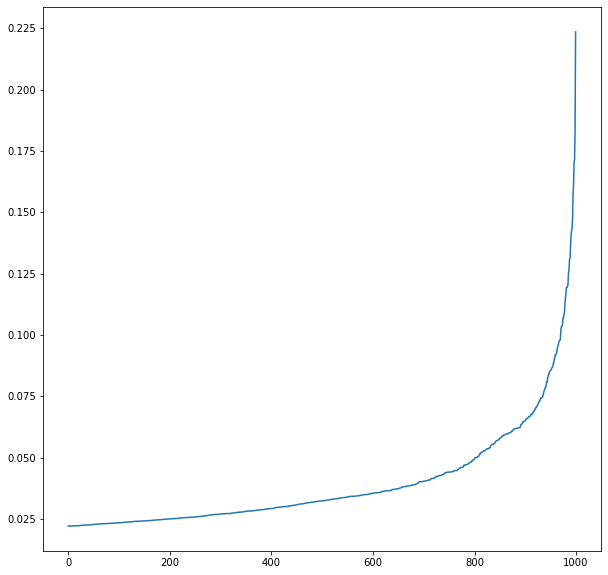

In [8]:
#Selecionando o melhor valor para o eps
neigh = NearestNeighbors(n_neighbors=12)
nbrs = neigh.fit(data_norm)
distances, indices = nbrs.kneighbors(data_norm)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(5, figsize=(10,10))
plt.plot(distances[4000:5000]);

Forma identificadas 16 labels:
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}


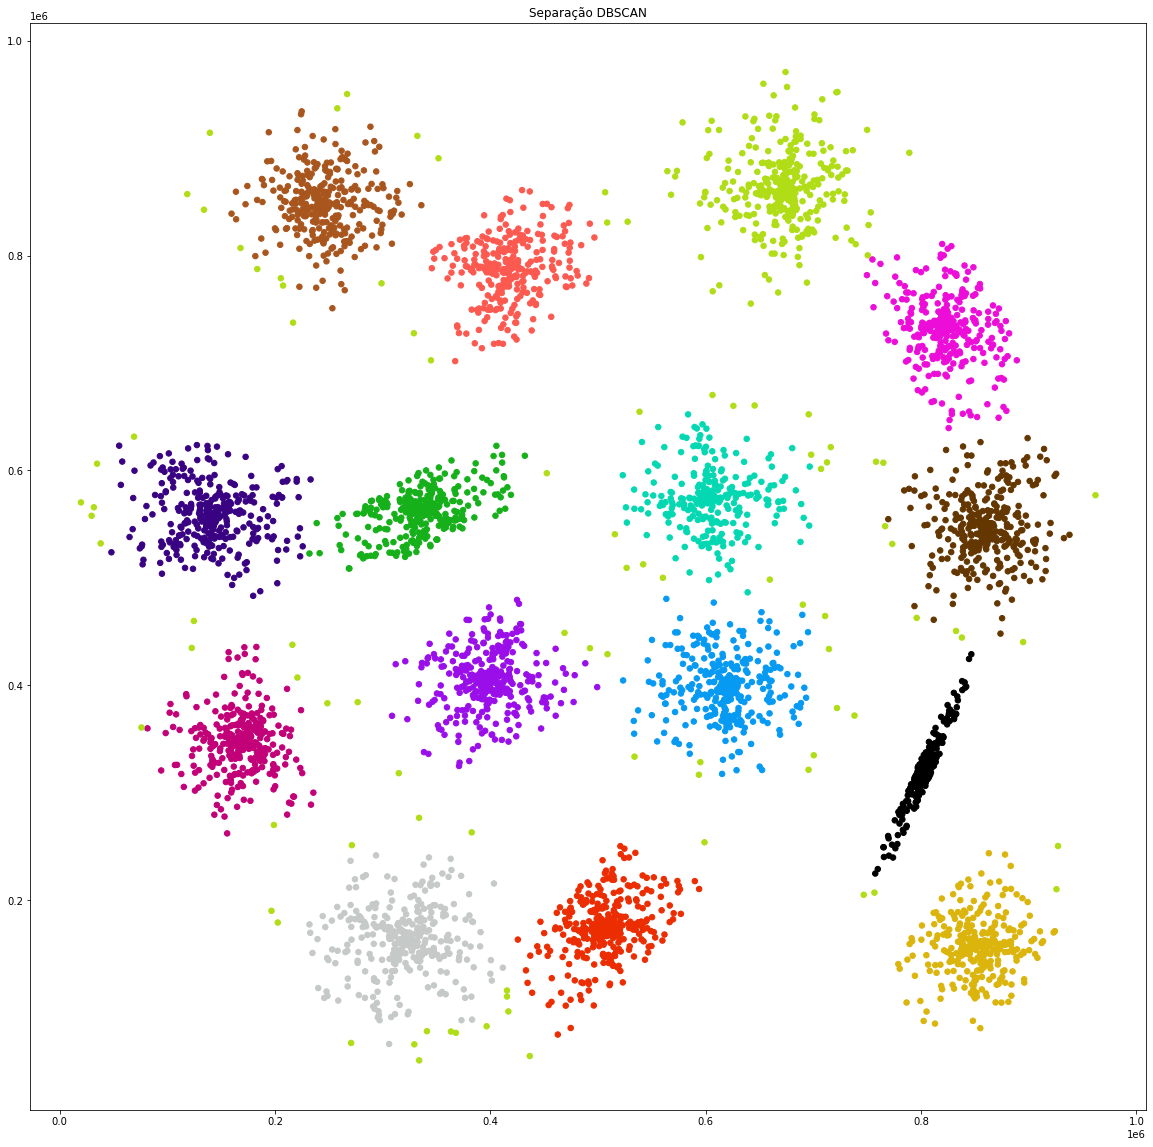

In [9]:
# O gráfico acima indica que o EPS ideal estaria entre 0.05 e 0.125, após alguns testes chegamos ao valor de 0.12 
dbsdata = data_norm.copy()

db = DBSCAN(eps=0.12, min_samples=12)
db.fit(dbsdata)
dbscan_labels = set(db.labels_)

print('Forma identificadas', len(dbscan_labels), 'labels:\n', dbscan_labels)

colormap = np.array(['#04d8b2', '#069af3', '#000000', '#653700', '#fc5a50', 
    '#ed0dd9', '#dbb40c', '#15b01a', '#380282', '#c20078', 
    '#a9561e', '#c5c9c7', '#ec2d01', '#9a0eea', '#b0dd16'])
vectorizer = np.vectorize(lambda x: colormap[x % len(colormap)])

plt.figure(6, figsize=(20,20))
plt.scatter(data.V1, data.V2, c=vectorizer(db.labels_), s=30)

plt.title('Separação DBSCAN')
plt.show();

In [10]:
# Encontrando o melhor epsilon via silhouette_score
X = data_norm.copy()

eps_grid = np.linspace(0.05, 0.20, num=10)
ms_grid = range(4, 30, 3)
eps_best = eps_grid[0]
ms_best = ms_grid[0]
silhouette_score_max = -1


for min_sample in ms_grid:
    for eps in eps_grid:
        # Treinar o DBSCAN cluster
        model = DBSCAN(eps=eps, min_samples=min_sample).fit(X)
        # Obter as labels
        labels = model.labels_
        if len(set(labels)) > 1:
            # Obter as mmetricas de performance
            silhouette_score = round(metrics.silhouette_score(X, labels), 4)
            if silhouette_score > silhouette_score_max:
                print("Epsilon:", round(eps, 4), "Min Sample: ", min_sample, "--> silhouette score:", silhouette_score)
                silhouette_score_max = silhouette_score
                eps_best = eps
                ms_best = min_sample

# Melhores (hiper)parametros
print("Melhor epsilon =", eps_best, "e melhor min sample =", ms_best)

Epsilon: 0.05 Min Sample:  4 --> silhouette score: 0.2425
Epsilon: 0.0667 Min Sample:  4 --> silhouette score: 0.4938
Epsilon: 0.0833 Min Sample:  4 --> silhouette score: 0.5634
Epsilon: 0.0833 Min Sample:  7 --> silhouette score: 0.6449
Epsilon: 0.1 Min Sample:  10 --> silhouette score: 0.6788
Epsilon: 0.1167 Min Sample:  13 --> silhouette score: 0.689
Epsilon: 0.1333 Min Sample:  16 --> silhouette score: 0.6976
Melhor epsilon = 0.13333333333333336 e melhor min sample = 16


Forma identificadas 16 labels:
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}


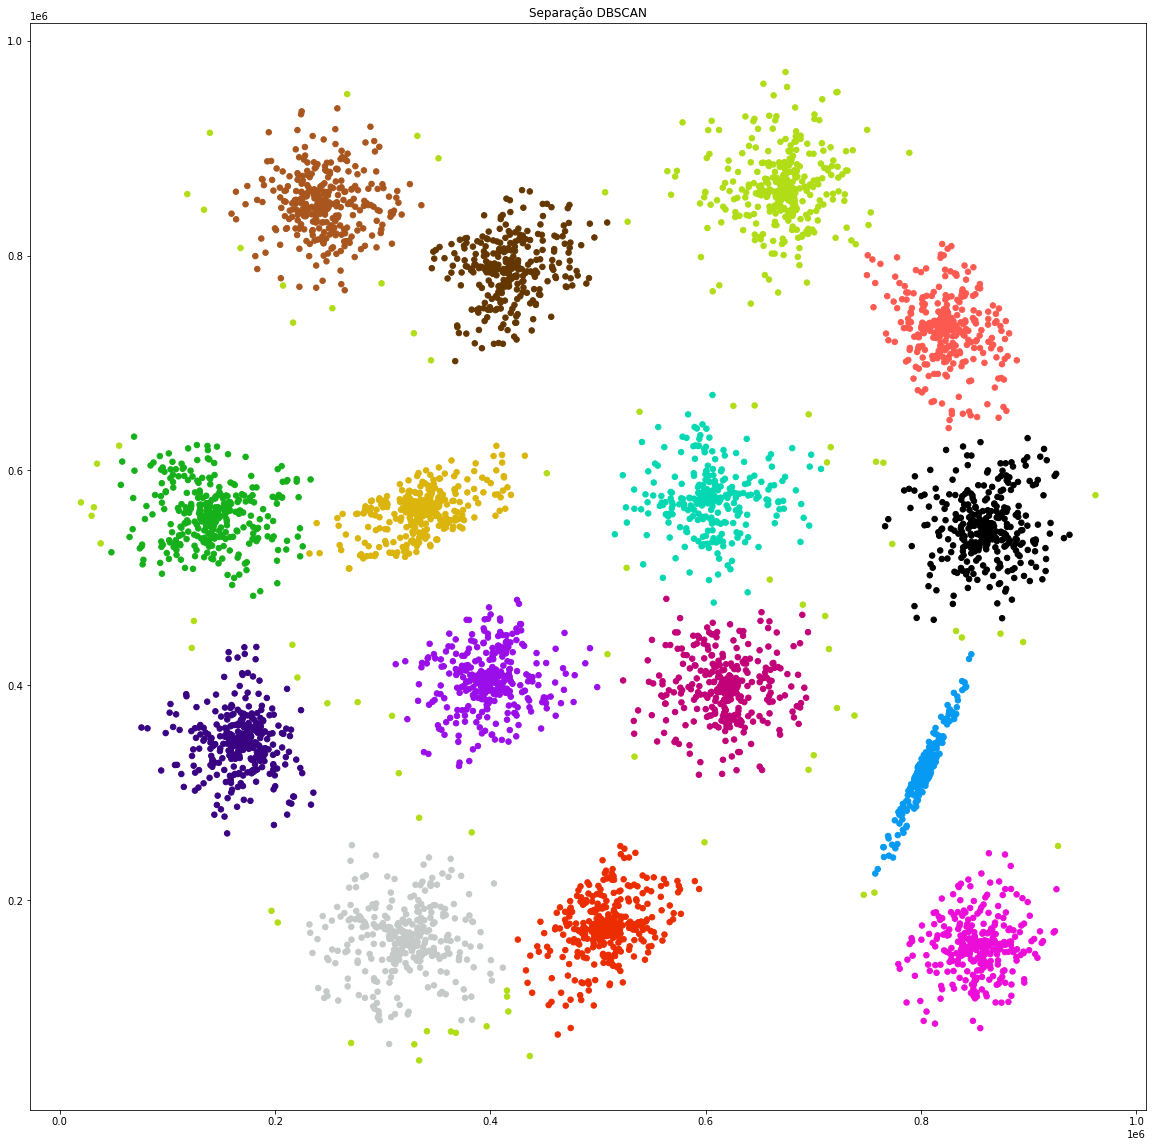

In [11]:
# Aplicando o melhor combinação encontrada via silhouete score
dbsdata = data_norm.copy()

db = DBSCAN(eps=eps_best, min_samples=ms_best)
db.fit(dbsdata)
dbscan_labels = set(db.labels_)

print('Forma identificadas', len(dbscan_labels), 'labels:\n', dbscan_labels)

colormap = np.array(['#04d8b2', '#069af3', '#000000', '#653700', '#fc5a50', 
    '#ed0dd9', '#dbb40c', '#15b01a', '#380282', '#c20078', 
    '#a9561e', '#c5c9c7', '#ec2d01', '#9a0eea', '#b0dd16'])
vectorizer = np.vectorize(lambda x: colormap[x % len(colormap)])

plt.figure(6, figsize=(20,20))
plt.scatter(data.V1, data.V2, c=vectorizer(db.labels_), s=30)

plt.title('Separação DBSCAN')
plt.show();

# Conclusão 

Podemos notar que para este dataset especifico, dos 15 clusters visualmente reconhecidos a melhor combinação encontrada de DBSCAN fpo capaz de clusterizar 14 deles deixando um dos cluestes e alguns dos pontos mais distantes dos centróides como não identificados.   
O melhor método a ser aplicado neste dataset é o K-Means, pois foi capaz de reconhecer corretamente os clusters, exceto alguns pontos relacionados ao cluster preto que possui formado mais achatado que os demais (todos este pontos podem ser considerados ruído).